In [13]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Authenticate and initialize GEE
try:
    ee.Initialize(project='ee-shraddhagourishetty')
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='ee-shraddhagourishetty')

# Load Sudan municipal boundaries
sudan_boundary = ee.FeatureCollection('projects/ee-shraddhagourishetty/assets/sudan_boundary')
krt_boundary = sudan_boundary.filter(ee.Filter.inList('name', ['South Kordofan']))

# Map display
map_center = [15.5, 32.5]
map_obj = geemap.Map(center=[15.5, 32.5], zoom=6)
map_obj.addLayer(krt_boundary, {}, 'Region')
map_obj

Map(center=[15.5, 32.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [16]:
#Resampling MODIS data to SMAP spatial resolution, and calculate mean value of February and October months from the year 2016 to 2024 and display using interactive map

# Define the time range
start_year = 2016
end_year = 2024

# Function to apply MODIS cloud mask
def mask_modis_clouds(img):
    qc = img.select("QC_Day")  
    mask = qc.bitwiseAnd(3).eq(0)  
    return img.updateMask(mask)  

# Function to compute MODIS yearly mean with conversion & normalization
def compute_modis_yearly_mean(year):
    start_date = ee.Date.fromYMD(year, 2, 1)
    end_date = ee.Date.fromYMD(year, 2, 28)

    # Get MODIS LST ImageCollection for the month
    modis_collection = ee.ImageCollection("MODIS/061/MOD11A1") \
        .filterDate(start_date, end_date) \
        .filterBounds(krt_boundary) \
        .map(mask_modis_clouds) \
        .select("LST_Day_1km") \
        .map(lambda img: img.toFloat())

    # Ensure collection is not empty
    modis_count = modis_collection.size()
    modis_yearly = ee.Algorithms.If(modis_count.gt(0), modis_collection.mean(), None)

    # Handle None cases
    if modis_yearly is None:
        return None

    modis_yearly = ee.Image(modis_yearly)

    # Convert MODIS LST from Kelvin to Celsius (MODIS stores LST in Kelvin × 50)
    modis_celsius = modis_yearly.multiply(0.02).subtract(273.15)

    # Compute min and max for normalization
    min_val = modis_celsius.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=krt_boundary,
        scale=11000,
        bestEffort=True
    ).get("LST_Day_1km")

    max_val = modis_celsius.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=krt_boundary,
        scale=11000,
        bestEffort=True
    ).get("LST_Day_1km")

    # Ensure min/max are valid
    min_val = ee.Algorithms.If(ee.Algorithms.IsEqual(min_val, None), 0, min_val)
    max_val = ee.Algorithms.If(ee.Algorithms.IsEqual(max_val, None), 0.5, max_val)

    # Convert min_val & max_val to ee.Image before using subtract() and divide()
    min_val_image = ee.Image.constant(min_val)
    max_val_image = ee.Image.constant(max_val)

    # Normalize MODIS LST (scaled between 0 and 1)
    modis_norm = modis_celsius.subtract(min_val_image) \
                             .divide(max_val_image.subtract(min_val_image))

    return modis_norm.clip(krt_boundary).set("year", year)


# Function to compute SMAP Soil Moisture yearly mean
def compute_smap_yearly_mean(year):
    start_date = ee.Date.fromYMD(year, 2, 1)
    end_date = ee.Date.fromYMD(year, 2, 28)

    # Get SMAP data 
    smap_collection = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007") \
        .filterDate(start_date, end_date) \
        .filterBounds(krt_boundary) \
        .select("sm_surface")

    # Ensure collection is not empty
    smap_count = smap_collection.size()
    smap_yearly = ee.Algorithms.If(smap_count.gt(0), smap_collection.mean(), None)

    if smap_yearly is None:
        return None

    smap_yearly = ee.Image(smap_yearly)

    # Compute min and max for normalization
    min_val = smap_yearly.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=krt_boundary,
        scale=11000,
        bestEffort=True
    ).get("sm_surface")

    max_val = smap_yearly.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=krt_boundary,
        scale=11000,
        bestEffort=True
    ).get("sm_surface")

    # Ensure min/max are valid
    min_val = ee.Algorithms.If(ee.Algorithms.IsEqual(min_val, None), 0, min_val)
    max_val = ee.Algorithms.If(ee.Algorithms.IsEqual(max_val, None), 0.5, max_val)

    # Convert min_val & max_val to ee.Image before using subtract() and divide()
    min_val_image = ee.Image.constant(min_val)
    max_val_image = ee.Image.constant(max_val)

    # Normalize SMAP Soil Moisture (scaled between 0 and 1)
    smap_norm = smap_yearly.subtract(min_val_image) \
                            .divide(max_val_image.subtract(min_val_image))

    return smap_norm.clip(krt_boundary).set("year", year)

# Generate yearly MODIS and SMAP images
modis_collection = ee.ImageCollection([compute_modis_yearly_mean(year) for year in range(start_year, end_year + 1)]).filter(ee.Filter.notNull(["year"]))
smap_collection = ee.ImageCollection([compute_smap_yearly_mean(year) for year in range(start_year, end_year + 1)]).filter(ee.Filter.notNull(["year"]))


# Resample all MODIS images in the collection to match SMAP
smap_proj = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007").first().projection()

# Resample MODIS to match SMAP resolution using bilinear interpolation
modis_resampled_collection = modis_collection.map(
    lambda img: img \
        .setDefaultProjection(crs=smap_proj.crs(), scale=smap_proj.nominalScale()) \
        .reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024) \
        .resample("bilinear") \
        .reproject(crs=smap_proj.crs(), scale=smap_proj.nominalScale()) \
        .set("year", img.get("year"))
)

# Visualization parameters
modis_vis = {"min": -1, "max": 1, "palette": ["darkred", "red", "yellow", "lightblue", "darkblue"]}
smap_vis = {"min": -1, "max": 1, "palette": ["brown", "orange", "yellow", "green", "blue"]}

# Create an interactive map
Map = geemap.Map(center=[15.5, 32.5], zoom=6)

# Select one year (e.g., 2024) to display on the map
selected_year = 2016
modis_selected = modis_resampled_collection.filter(ee.Filter.eq("year", selected_year)).first()
smap_selected = smap_collection.filter(ee.Filter.eq("year", selected_year)).first()


# Add layers
Map.addLayer(modis_selected, modis_vis, f"MODIS LST ({selected_year})")
Map.addLayer(smap_selected, smap_vis, f"SMAP Soil Moisture ({selected_year})")
Map.addLayer(krt_boundary.style(color="white", width=2), {}, "KRT Boundary")

# Display map
Map



Map(center=[15.5, 32.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

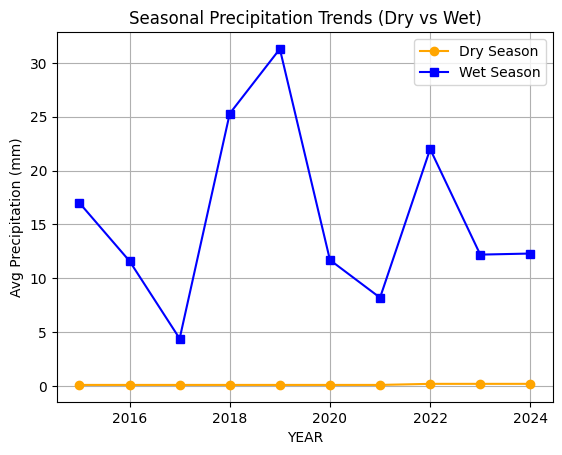

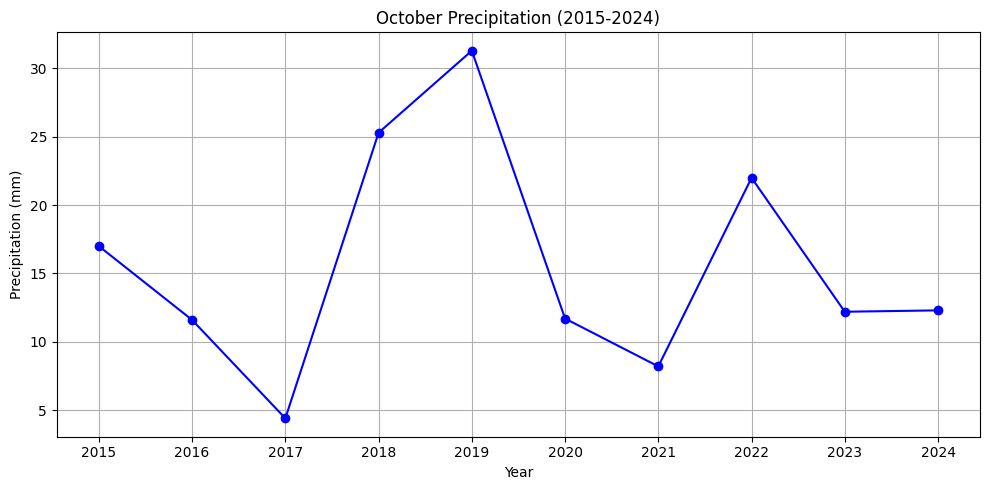

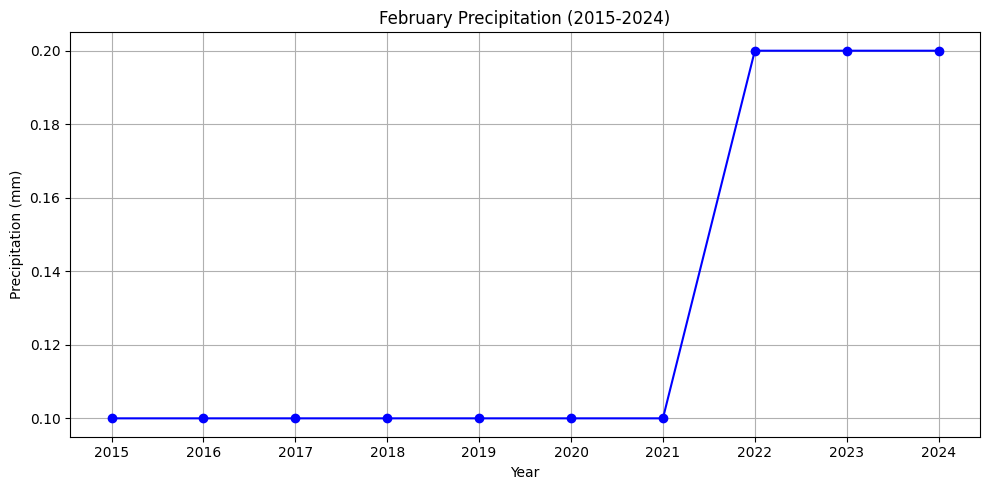

In [66]:

# displaying percipitation values from 2015 to 2016 on a time-series graph
# for a better understanding of the MODIS and SMAP data in terms of soil moisture
# one of the ways doing this is, extraction the percipitation values through the region's climate data manually and creating a csv file for analysis

# Load local GPM precipitation data (CSV must have Year, Month, Precipitation columns)
gpm_df = pd.read_csv('/Users/shraddha/Documents/5th_Year/2nd_Semester/GEOG 471/Data Collected/sudan_precip_2015_2024.csv')  

# Clean column names
gpm_df.columns = gpm_df.columns.str.strip().str.upper()

# Convert columns JAN-DEC into rows
gpm_long = gpm_df.melt(id_vars=["YEAR"], var_name="Month", value_name="Precipitation")



# Map month names to numbers
month_map = {
    "JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6,
    "JUL": 7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12
}
gpm_long["Month"] = gpm_long["Month"].str.upper().map(month_map)

# Define seasons
dry_months = [2]
wet_months = [10]

# Calculate seasonal means
dry_df = gpm_long[gpm_long["Month"].isin(dry_months)] \
    .groupby("YEAR")["Precipitation"].mean().reset_index(name="Dry_Season")

wet_df = gpm_long[gpm_long["Month"].isin(wet_months)] \
    .groupby("YEAR")["Precipitation"].mean().reset_index(name="Wet_Season")

# Merge both
seasonal_df = pd.merge(dry_df, wet_df, on="YEAR", how="outer").sort_values("YEAR")

plt.plot(seasonal_df["YEAR"], seasonal_df["Dry_Season"], marker='o', label="Dry Season", color="orange")
plt.plot(seasonal_df["YEAR"], seasonal_df["Wet_Season"], marker='s', label="Wet Season", color="blue")
plt.title("Seasonal Precipitation Trends (Dry vs Wet)")
plt.xlabel("YEAR")
plt.ylabel("Avg Precipitation (mm)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(gpm_df["YEAR"], gpm_df["OCT"], marker='o', linestyle='-', color='blue')
plt.title("October Precipitation (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.xticks(gpm_df["YEAR"])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(gpm_df["YEAR"], gpm_df["FEB"], marker='o', linestyle='-', color='blue')
plt.title("February Precipitation (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.xticks(gpm_df["YEAR"])
plt.tight_layout()
plt.show()


In [3]:
# Another way the percipitation values can be extracted using GPM level 3 image collection data on Google Earth Engine

def extract_normalized_gpm_oct_feb(start_year, end_year, region):
    import pandas as pd

    # Collect values here
    raw_values = []
    rows = []

    for year in range(start_year, end_year + 1):
        for month in [2, 10]:  # Feb and Oct only
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            # Filter GPM monthly data
            collection = ee.ImageCollection('NASA/GPM_L3/IMERG_V07') \
                .filterDate(start, end)

            if collection.size().getInfo() == 0:
                print(f"No data for {year}-{month:02d}")
                continue

            # Mean image for the month
            img = collection.select("precipitation").mean() \
                .resample("bilinear") \
                .reproject(crs="EPSG:4326", scale=11000)

            # Reduce to regional average
            val = img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=11000,
                maxPixels=1e9
            ).get("precipitation")

            try:
                val = ee.Number(val).getInfo()
            except:
                val = None

            if val is not None:
                raw_values.append(val)
                rows.append({"Year": year, "Month": month, "Precip_mm": val})

    # Create DataFrame
    df = pd.DataFrame(rows)

    # Normalize values
    if not df.empty:
        min_val = df["Precip_mm"].min()
        max_val = df["Precip_mm"].max()
        df["Normalized"] = (df["Precip_mm"] - min_val) / (max_val - min_val)

    return df

gpm_feb_oct_df = extract_normalized_gpm_oct_feb(2016, 2024, krt_boundary)
print(gpm_feb_oct_df)



    Year  Month  Precip_mm  Normalized
0   2016      2   0.000450    0.010936
1   2016     10   0.005177    0.133866
2   2017      2   0.001707    0.043622
3   2017     10   0.001122    0.028417
4   2018      2   0.000811    0.020311
5   2018     10   0.038483    1.000000
6   2019      2   0.001323    0.033640
7   2019     10   0.016544    0.429464
8   2020      2   0.001325    0.033685
9   2020     10   0.005539    0.143283
10  2021      2   0.001271    0.032274
11  2021     10   0.002244    0.057585
12  2022      2   0.000165    0.003527
13  2022     10   0.007410    0.191916
14  2023      2   0.000250    0.005726
15  2023     10   0.006111    0.158160
16  2024      2   0.000030    0.000000
17  2024     10   0.007138    0.184848


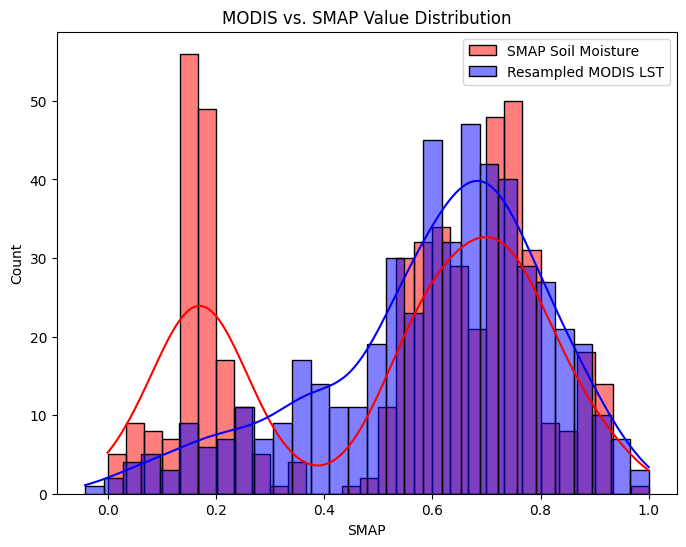

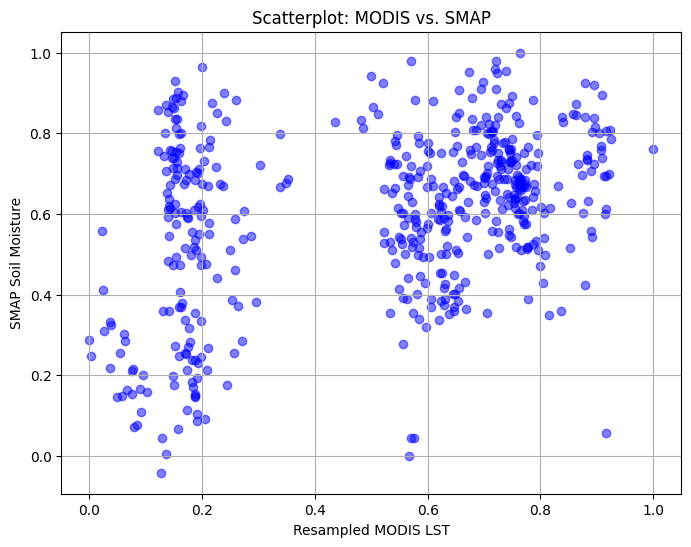

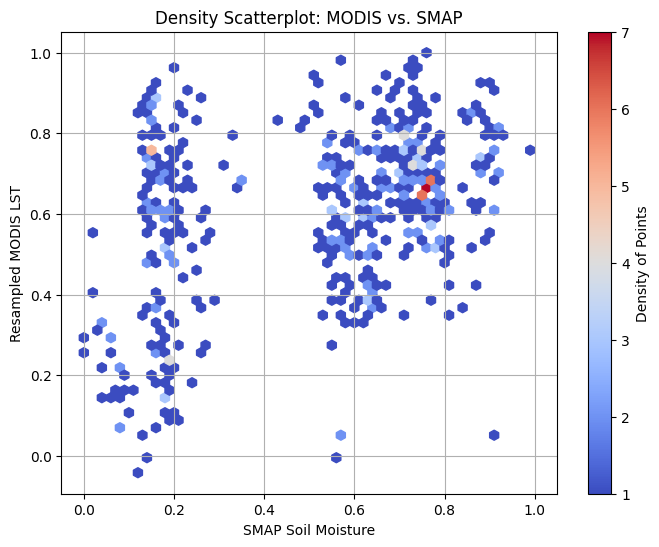

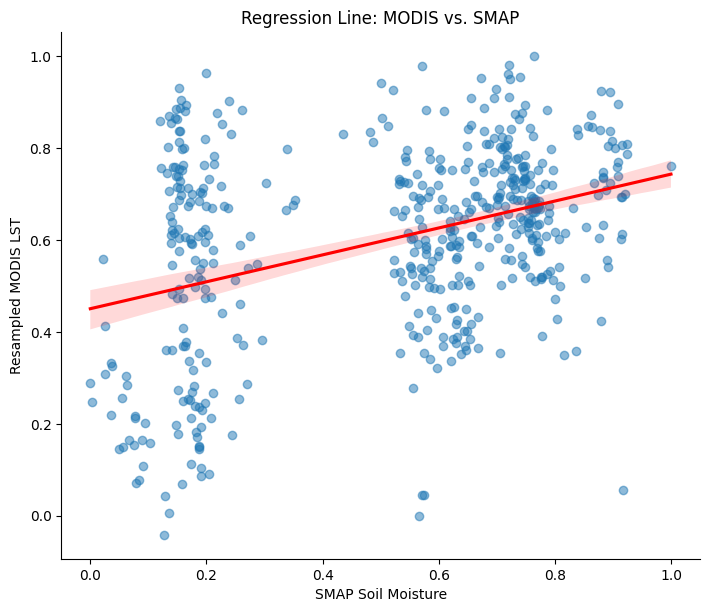

R² Score: -0.1112 (Higher is better)
RMSE: 0.2820 (Lower is better)
SMAP Summary:
 count    511.000000
mean       0.519712
std        0.267763
min        0.000000
25%        0.197269
50%        0.606735
75%        0.739242
max        1.000000
Name: SMAP, dtype: float64
MODIS Summary:
 count    511.000000
mean       0.602271
std        0.207643
min       -0.041643
25%        0.501925
50%        0.642185
75%        0.747960
max        1.000000
Name: MODIS, dtype: float64
Unique SMAP Values: 511
Unique MODIS Values: 504
Missing Values:
 SMAP     0
MODIS    0
dtype: int64


In [17]:
# Scatterplot displaying if modis data images correctly fall within smap data images to check accuracy

# Function to extract pixel values from SMAP & MODIS (Resampled)
def get_sample_points(smap_collection, modis_resampled_collection, region, num_points=500):
    """Extracts pixel values from SMAP (Base) and Resampled MODIS."""
    
    # Use the latest available SMAP image as the base
    smap_image = smap_collection.sort("year", False).first()
    modis_image = modis_resampled_collection.sort("year", False).first()
    #gpm_image = gpm_resampled_collection.sort("year", False).first()

    # Check if images exist
    if smap_image is None or modis_image is None:
        print("Error: No valid SMAP or MODIS data found for sampling.")
        return pd.DataFrame()  # Return empty DataFrame

    # Merge both images for joint sampling
    merged_images = smap_image.addBands(modis_image)
    #.addBands(gpm_image)

    # Sample points using SMAP's resolution (11 km)
    sample = merged_images.sample(
        region=region, numPixels=num_points, scale=11000
    )

    # Convert sampled points to Pandas DataFrame
    data = sample.getInfo()
    
    return pd.DataFrame(
        [[f["properties"]["sm_surface"], f["properties"]["LST_Day_1km"]] for f in data["features"]],
        columns=["SMAP", "MODIS"]
    )

# Get sampled pixel data
data = get_sample_points(smap_collection, modis_resampled_collection, krt_boundary)

data["SMAP"] = pd.to_numeric(data["SMAP"], errors="coerce")
data["MODIS"] = pd.to_numeric(data["MODIS"], errors="coerce")
#data["Precipitation"] = pd.to_numeric(data["Precipitation"], errors="coerce")


# Check if data is empty
if data.empty:
    print("No sampled data points found. Try adjusting the sampling region or dataset.")
else:
    # Plot histograms for value distributions
    plt.figure(figsize=(8,6))
    sns.histplot(data["SMAP"], color="red", label="SMAP Soil Moisture", kde=True, bins=30)
    sns.histplot(data["MODIS"], color="blue", label="Resampled MODIS LST", kde=True, bins=30)
    #sns.histplot(data["Precipitation"], color="green", label="GPM Precipitation", kde=True, bins=30)
    plt.legend()
    plt.title("MODIS vs. SMAP Value Distribution")
    plt.show()

    # Scatterplot
    plt.figure(figsize=(8,6))
    plt.scatter(data["SMAP"], data["MODIS"], alpha=0.5, color="blue")
    plt.xlabel("Resampled MODIS LST")
    plt.ylabel("SMAP Soil Moisture")
    plt.title("Scatterplot: MODIS vs. SMAP")
    plt.grid(True)
    plt.show()

    # Density Plot (Hexbin)
    plt.figure(figsize=(8,6))
    plt.hexbin(data["SMAP"], data["MODIS"], gridsize=50, cmap="coolwarm", mincnt=1)
    plt.colorbar(label="Density of Points")
    plt.xlabel("SMAP Soil Moisture")
    plt.ylabel("Resampled MODIS LST")
    plt.title("Density Scatterplot: MODIS vs. SMAP")
    plt.grid(True)
    plt.show()

    # Regression Plot
    sns.lmplot(x="SMAP", y="MODIS", data=data, height=6, aspect=1.2, scatter_kws={"alpha":0.5}, line_kws={"color": "red"})
    plt.xlabel("SMAP Soil Moisture")
    plt.ylabel("Resampled MODIS LST")
    plt.title("Regression Line: MODIS vs. SMAP")
    plt.show()

    # Compute R² and RMSE
    r2 = r2_score(data["SMAP"], data["MODIS"])
    rmse = np.sqrt(mean_squared_error(data["SMAP"], data["MODIS"]))

    print(f"R² Score: {r2:.4f} (Higher is better)")
    print(f"RMSE: {rmse:.4f} (Lower is better)")

print("SMAP Summary:\n", data["SMAP"].describe())
print("MODIS Summary:\n", data["MODIS"].describe())

# Check unique values
print("Unique SMAP Values:", data["SMAP"].nunique())
print("Unique MODIS Values:", data["MODIS"].nunique())

# Check if there are NaN values
print("Missing Values:\n", data.isnull().sum())

In [230]:
# Calculate TMDI (Temperature Moisture Dryness Index) and SSI (Standardized Soil Moisture Index) for modis and smap before classifying 
# and SPI (Standardized Percipitation Index) from percipitation values

# Function to compute SPI for Precipitation through the first method of extracting percipitation values
'''
# Filter October (or any month)
data = gpm_long[gpm_long["Month"] == 10].copy()

# Calculate mean and std deviation
mean_precip = data["Precipitation"].mean()
std_precip = data["Precipitation"].std()

# Manually calculate SPI
data["SPI"] = (data["Precipitation"] - mean_precip) / std_precip

# Contains YEAR and SPI columns
gpm_df = data[["YEAR", "SPI"]].copy()
gpm_df.rename(columns={"YEAR": "Year"}, inplace=True)

print(data[["YEAR", "Precipitation", "SPI"]])
'''

# Calculate SPI for Feb and Oct through the second method of extracting percipitation values (which was used)
spi_results = []

for month in [2, 10]:
    sub = gpm_feb_oct_df[gpm_feb_oct_df["Month"] == month].copy()
    mean = sub["Precip_mm"].mean()
    std = sub["Precip_mm"].std()
    sub["SPI"] = (sub["Precip_mm"] - mean) / std
    spi_results.append(sub)

spi_df = pd.concat(spi_results).sort_values(by=["Year", "Month"])
print(spi_df[["Year", "Month", "Precip_mm", "SPI"]])

spi_wide = spi_df.pivot(index="Year", columns="Month", values="SPI").rename(columns={2: "SPI_Feb", 10: "SPI_Oct"})
spi_wide["SPI_Feb-Oct_Diff"] = spi_wide["SPI_Feb"] - spi_wide["SPI_Oct"]
print(spi_wide)


# Function to compute MODIS TMDI using Resampled LST
def calculate_tmdi_no_ndvi(img):
    lst = img.select("LST_Day_1km")

    # Compute global min/max LST across all years
    lst_min = modis_resampled_collection.select("LST_Day_1km").min()
    lst_max = modis_resampled_collection.select("LST_Day_1km").max()

    # Avoid division by zero errors
    lst_range = lst_max.subtract(lst_min).where(lst_max.subtract(lst_min).eq(0), 1)

    # Compute TMDI
    tmdi = lst.subtract(lst_min).divide(lst_range)
    tmdi = ee.Image(1).subtract(tmdi).rename("TMDI")

    return img.addBands([tmdi, lst])

# Function to compute SSI for MODIS (TMDI-based) & SMAP
def calculate_ssi(image_collection, band_name):
    # Compute global mean and standard deviation of the band
    overall_mean = image_collection.select(band_name).mean()
    overall_std = image_collection.select(band_name).reduce(ee.Reducer.stdDev())

    # Avoid division by zero errors
    overall_std = overall_std.where(overall_std.eq(0), 1)

    # Compute SSI for each image in the collection
    def compute_ssi(img):
        ssi_img = img.select(band_name).subtract(overall_mean).divide(overall_std).rename(f"SSI_{band_name}")
        return img.addBands(ssi_img)

    return image_collection.map(compute_ssi)

# Compute TMDI for all MODIS images
modis_with_tmdi = modis_resampled_collection.map(calculate_tmdi_no_ndvi)

# Compute SSI for MODIS (using TMDI) & SMAP (using Soil Moisture)
modis_ssi = calculate_ssi(modis_with_tmdi, "TMDI")
smap_ssi = calculate_ssi(smap_collection, "sm_surface")

# Get the latest SSI Image for visualization
modis_ssi_nov = modis_ssi.sort("year", False).first().select("SSI_TMDI")
smap_ssi_nov = smap_ssi.sort("year", False).first().select("SSI_sm_surface")

modis_year_displayed = modis_ssi_nov.get("year").getInfo()
smap_year_displayed = smap_ssi_nov.get("year").getInfo()

selected_year = 2016
modis_ssi_nov = modis_ssi.filter(ee.Filter.eq("year", selected_year)).first().select("SSI_TMDI")
smap_ssi_nov = smap_ssi.filter(ee.Filter.eq("year", selected_year)).first().select("SSI_sm_surface")

# Define visualization parameters
modis_vis = {"min": -1, "max": 1, "palette": ["brown", "orange", "yellow", "green", "blue"]}
smap_vis = {"min": -1, "max": 1, "palette": ["brown", "orange", "yellow", "green", "blue"]}

# Display SSI maps
m = geemap.Map(center=[15.5, 32.5], zoom=6)
m.addLayer(modis_ssi_nov, modis_vis, "MODIS SSI")
m.addLayer(smap_ssi_nov, smap_vis, "SMAP SSI")
m

    Year  Month  Precip_mm       SPI
0   2016      2   0.000450 -0.593819
1   2016     10   0.005177 -0.415516
2   2017      2   0.001707  1.454152
3   2017     10   0.001122 -0.766749
4   2018      2   0.000811 -0.006420
5   2018     10   0.038483  2.469412
6   2019      2   0.001323  0.828740
7   2019     10   0.016544  0.569064
8   2020      2   0.001325  0.831549
9   2020     10   0.005539 -0.384149
10  2021      2   0.001271  0.743128
11  2021     10   0.002244 -0.669594
12  2022      2   0.000165 -1.058035
13  2022     10   0.007410 -0.222164
14  2023      2   0.000250 -0.920250
15  2023     10   0.006111 -0.334598
16  2024      2   0.000030 -1.279045
17  2024     10   0.007138 -0.245706
Month   SPI_Feb   SPI_Oct  SPI_Feb-Oct_Diff
Year                                       
2016  -0.593819 -0.415516         -0.178303
2017   1.454152 -0.766749          2.220901
2018  -0.006420  2.469412         -2.475832
2019   0.828740  0.569064          0.259676
2020   0.831549 -0.384149        

Map(center=[15.5, 32.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [231]:
# Conducting image differencing 

# Select two years for differencing 
year1 = 2016
year2 = 2024

# Select images for the chosen years
modis_ssi_1 = modis_ssi.filter(ee.Filter.eq("year", year1)).first()
modis_ssi_2 = modis_ssi.filter(ee.Filter.eq("year", year2)).first()

smap_ssi_1 = smap_ssi.filter(ee.Filter.eq("year", year1)).first()
smap_ssi_2 = smap_ssi.filter(ee.Filter.eq("year", year2)).first()

# Select the specific SSI band before subtraction
modis_ssi_diff = modis_ssi_2.select("SSI_TMDI").subtract(modis_ssi_1.select("SSI_TMDI"))
smap_ssi_diff = smap_ssi_2.select("SSI_sm_surface").subtract(smap_ssi_1.select("SSI_sm_surface"))


# Define visualization parameters
modis_vis = {"min": -1, "max": 1, "palette": ["brown", "orange", "yellow", "green", "blue"]}
smap_vis = {"min": -1, "max": 1, "palette": ["brown", "orange", "yellow", "green", "blue"]}

# Display SSI maps
m = geemap.Map(center=[15.5, 32.5], zoom=6)
m.addLayer(modis_ssi_diff, modis_vis, f"MODIS SSI Difference ({year1}-{year2})")
m.addLayer(smap_ssi_diff, smap_vis, f"SMAP SSI Difference ({year1}-{year2})")
m

Map(center=[15.5, 32.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [164]:

# Extracting the images needed for the analysis

region = krt_boundary.first().geometry()

task = ee.batch.Export.image.toDrive(
    image=modis_ssi_diff,
    description="MODIS_SSI_Diff_2016_2024_redsea_oct",
    folder="GEE_exports",  # Your Google Drive folder name
    fileNamePrefix="MODIS_ssi_diff_2016_2024_khartoum_oct",
    region=region,   # Your region of interest
    scale=11000,           # Match the spatial resolution of MODIS
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
task.start()






In [232]:
# Line graph, histogram and percentiles, includes outliers, and the threshold has been not defined

# Function to extract yearly SSI values
def extract_ssi_values(ssi_collection, band_name):
    ssi_values = []
    years = list(range(start_year, end_year + 1))
    
    for year in years:
        img = ssi_collection.filter(ee.Filter.eq("year", year)).first()
        if img is None:
            ssi_values.append(np.nan)  # Append None if no data for the year
            continue

        mean_ssi = img.reduceRegion(ee.Reducer.mean(), krt_boundary, 11000).get(band_name)

        if mean_ssi is None:
            ssi_values.append(np.nan)  # Append NaN instead of 0
        else:
            ssi_values.append(ee.Number(mean_ssi).getInfo())  # Convert to Python list
    
    return pd.DataFrame({"Year": years, "SSI": ssi_values})

# Ensure these are ImageCollections
modis_ssi_nov = ee.ImageCollection(modis_ssi)  # Convert if necessary
smap_ssi_nov = ee.ImageCollection(smap_ssi)

# Extract SSI values for MODIS & SMAP
modis_ssi_df = extract_ssi_values(modis_ssi_nov, "SSI_TMDI").fillna(np.nan) 
smap_ssi_df = extract_ssi_values(smap_ssi_nov, "SSI_sm_surface").fillna(np.nan)

# Merge MODIS, SMAP SSI data and SPI
spi_diff_df = spi_wide[["SPI_Oct"]].reset_index()
ssi_df = modis_ssi_df.merge(smap_ssi_df, on="Year", suffixes=("_MODIS", "_SMAP"))
ssi_df = ssi_df.merge(spi_diff_df, on="Year", how="left")





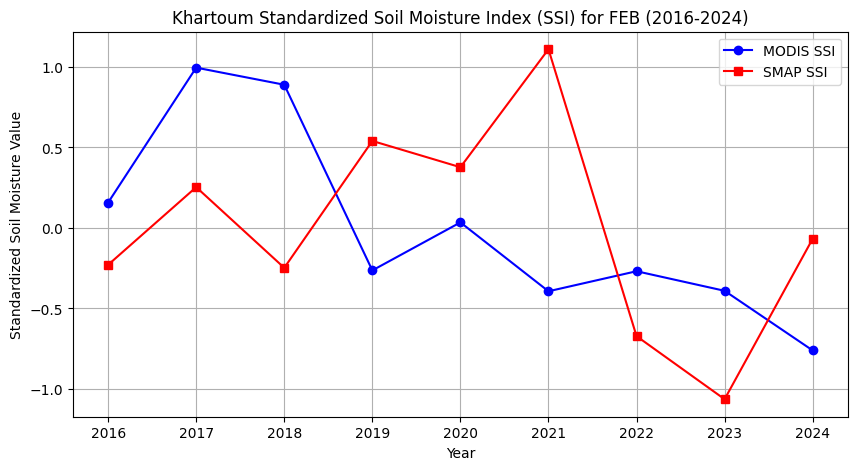

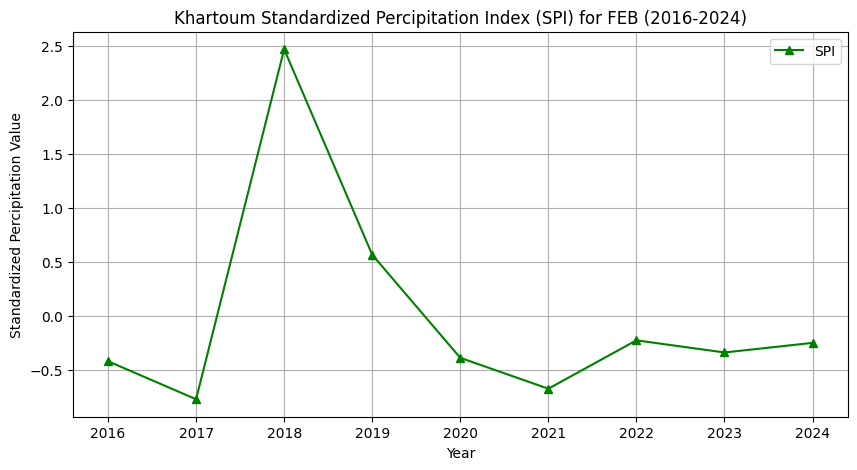

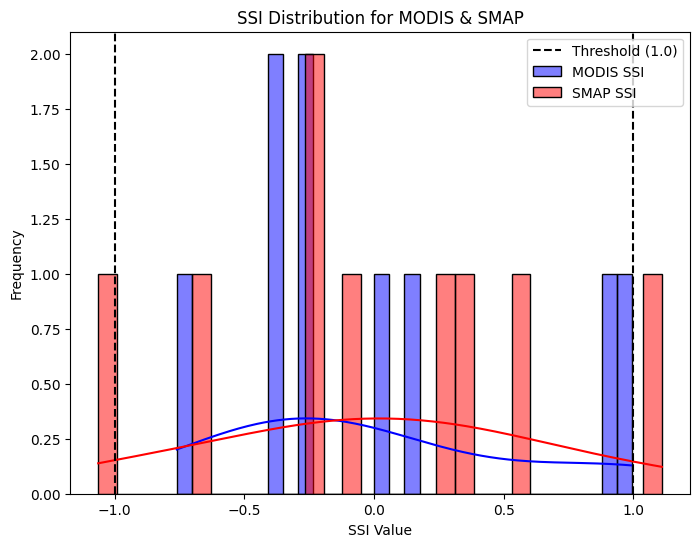

      SSI_MODIS  SSI_SMAP
0.05  -0.613801 -0.907078
0.25  -0.390545 -0.247812
0.50  -0.263808 -0.067254
0.75   0.157468  0.376894
0.95   0.952819  0.881874


In [233]:
# Plot SSI Time-Series for MODIS & SMAP 
plt.figure(figsize=(10,5))
plt.plot(ssi_df["Year"], ssi_df["SSI_MODIS"], marker='o', linestyle='-', color='blue', label="MODIS SSI")
plt.plot(ssi_df["Year"], ssi_df["SSI_SMAP"], marker='s', linestyle='-', color='red', label="SMAP SSI")
plt.xlabel("Year")
plt.ylabel("Standardized Soil Moisture Value")
plt.title("Khartoum Standardized Soil Moisture Index (SSI) for FEB (2016-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ssi_df["Year"], ssi_df["SPI_Oct"], marker='^', linestyle='-', color='green', label="SPI")
plt.xlabel("Year")
plt.ylabel("Standardized Percipitation Value")
plt.title("Khartoum Standardized Percipitation Index (SPI) for FEB (2016-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(ssi_df["SSI_MODIS"], bins=30, kde=True, color="blue", label="MODIS SSI")
sns.histplot(ssi_df["SSI_SMAP"], bins=30, kde=True, color="red", label="SMAP SSI")
#sns.histplot(ssi_df["SPI"], bins=30, kde=True, color="green", label="SPI")
plt.axvline(1.0, color="black", linestyle="--", label="Threshold (1.0)")
plt.axvline(-1.0, color="black", linestyle="--")
plt.xlabel("SSI Value")
plt.ylabel("Frequency")
plt.title("SSI Distribution for MODIS & SMAP")
plt.legend()
plt.show()

# Calculate key percentiles
percentiles = ssi_df[["SSI_MODIS", "SSI_SMAP"]].quantile([0.05, 0.25, 0.50, 0.75, 0.95])
print(percentiles)

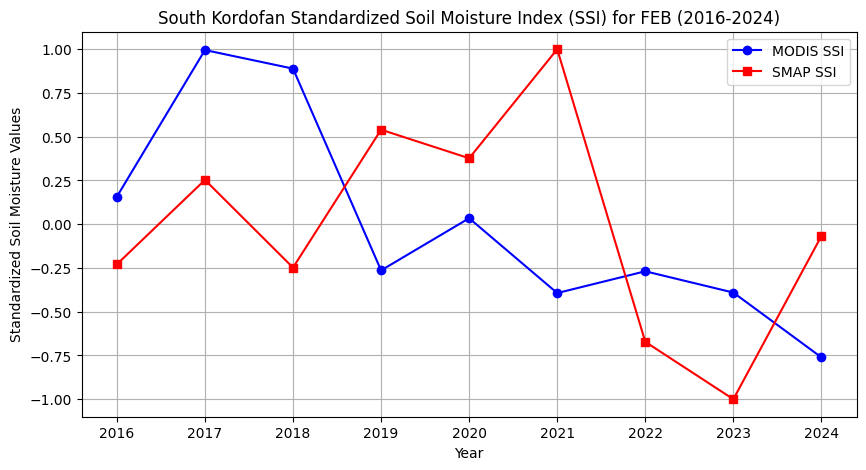

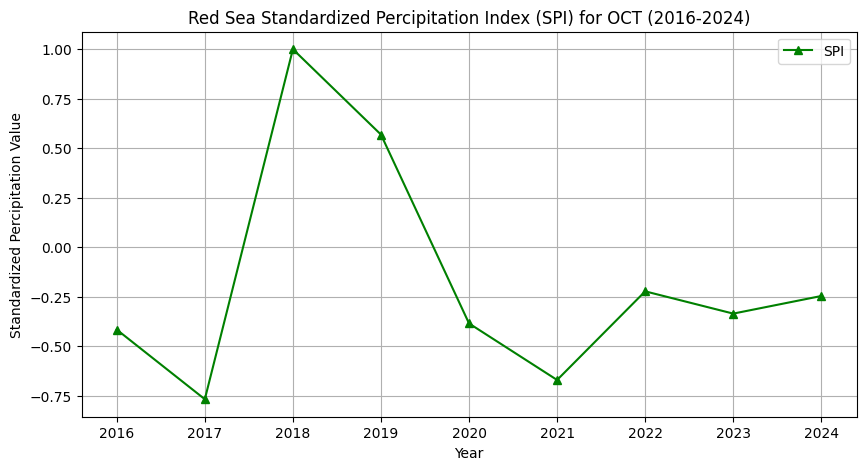

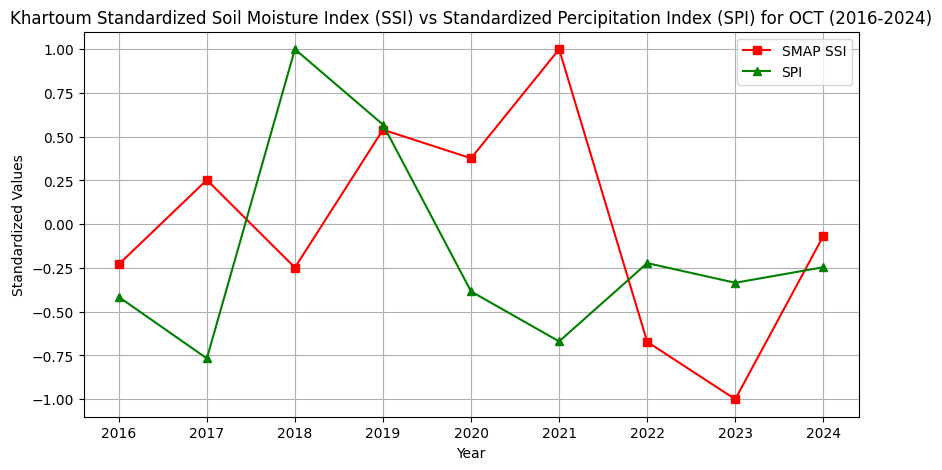

0    0.157468
1    0.995315
2    0.889074
3   -0.263808
4    0.034303
5   -0.393358
6   -0.268910
7   -0.390545
8   -0.760762
Name: SSI_MODIS, dtype: float64
0   -0.229004
1    0.253165
2   -0.247812
3    0.540143
4    0.376894
5    1.000000
6   -0.672086
7   -1.000000
8   -0.067254
Name: SSI_SMAP, dtype: float64
0   -0.415516
1   -0.766749
2    1.000000
3    0.569064
4   -0.384149
5   -0.669594
6   -0.222164
7   -0.334598
8   -0.245706
Name: SPI_Oct, dtype: float64


In [234]:
# Line graph excluding outliers

# Merge MODIS and SMAP SSI data
ssi_df = modis_ssi_df.merge(smap_ssi_df, on="Year", suffixes=("_MODIS", "_SMAP"))
ssi_df = ssi_df.merge(spi_diff_df, on="Year", how="left")
ssi_df["SSI_MODIS"] = ssi_df["SSI_MODIS"].clip(lower=-1.0, upper=1.0)
ssi_df["SSI_SMAP"] = ssi_df["SSI_SMAP"].clip(lower=-1.0, upper=1.0)
ssi_df["SPI_Oct"] = ssi_df["SPI_Oct"].clip(lower=-1.0, upper=1.0)

# Drop rows with NaN values before calculating R² and RMSE
ssi_df_clean = ssi_df.dropna()

# Plot SSI Time-Series for MODIS & SMAP
plt.figure(figsize=(10,5))
plt.plot(ssi_df["Year"], ssi_df["SSI_MODIS"], marker='o', linestyle='-', color='blue', label="MODIS SSI")
plt.plot(ssi_df["Year"], ssi_df["SSI_SMAP"], marker='s', linestyle='-', color='red', label="SMAP SSI")
plt.xlabel("Year")
plt.ylabel("Standardized Soil Moisture Values")
plt.title("South Kordofan Standardized Soil Moisture Index (SSI) for FEB (2016-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ssi_df["Year"], ssi_df["SPI_Oct"], marker='^', linestyle='-', color='green', label="SPI")
plt.xlabel("Year")
plt.ylabel("Standardized Percipitation Value")
plt.title("Red Sea Standardized Percipitation Index (SPI) for OCT (2016-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ssi_df["Year"], ssi_df["SSI_SMAP"], marker='s', linestyle='-', color='red', label="SMAP SSI")
plt.plot(ssi_df["Year"], ssi_df["SPI_Oct"], marker='^', linestyle='-', color='green', label="SPI")
plt.xlabel("Year")
plt.ylabel("Standardized Values")
plt.title("Khartoum Standardized Soil Moisture Index (SSI) vs Standardized Percipitation Index (SPI) for OCT (2016-2024)")
plt.legend()
plt.grid(True)
plt.show()

print(ssi_df["SSI_MODIS"])  
print(ssi_df["SSI_SMAP"])
print(ssi_df["SPI_Oct"])

R²: 0.05551327435092823
RMSE: 0.5403151737634926


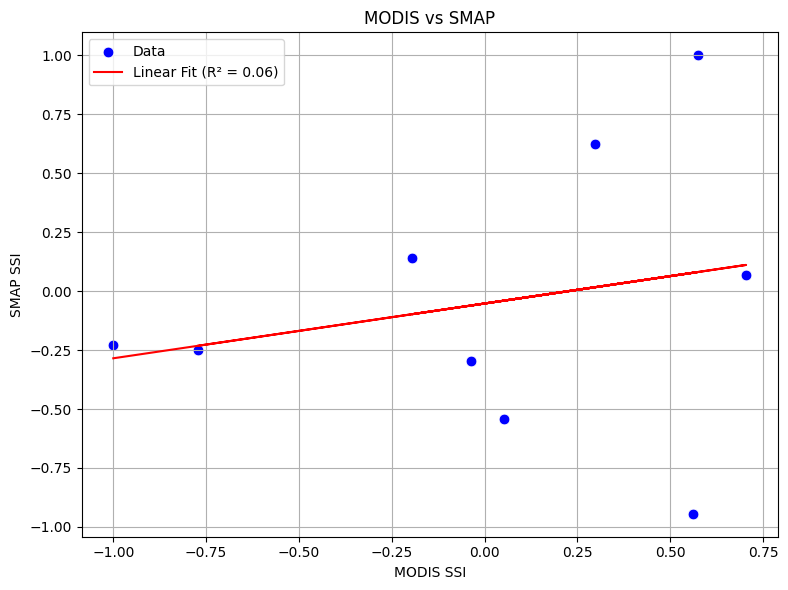

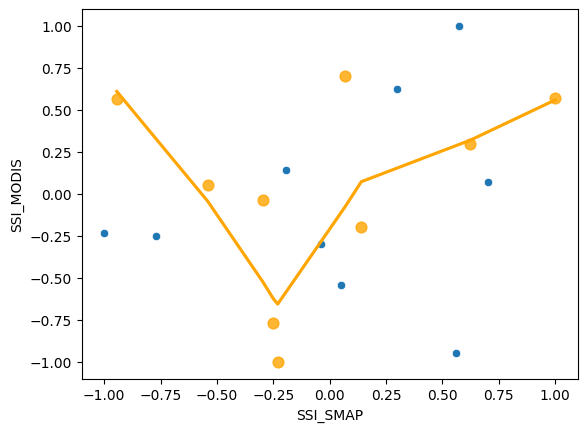

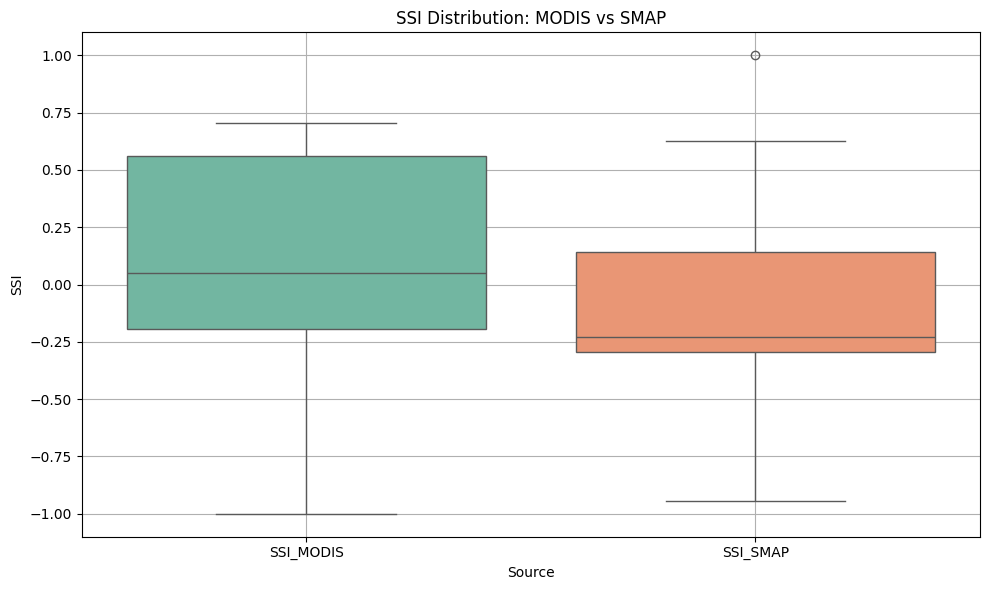

Bias (MODIS - SMAP): 0.0685


In [62]:
# Compute R² and RMSE for statistical analysis, one of the ways the analysis was conducted. Used the excel method for final results

# Extract X and Y
X = ssi_df_clean["SSI_MODIS"].values.reshape(-1, 1)
y = ssi_df_clean["SSI_SMAP"].values

# Fit regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate R²
r2 = r2_score(y, y_pred)
print(f"R²: {r2}")
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE: {rmse}")

# Scatterplot to visualize the alignment of MODIS and SMAP images after resampling
plt.figure(figsize=(8, 6))
sns.scatterplot(x="SSI_MODIS", y="SSI_SMAP", data=ssi_df_clean, s=60, color='blue', label='Data')
plt.plot(ssi_df_clean["SSI_MODIS"], y_pred, color='red', label=f"Linear Fit (R² = {r2:.2f})")
sns.scatterplot(x="SSI_MODIS", y="SSI_SMAP", data=ssi_df_clean)

# Regression plot to visualize the alignment of MODIS and SMAP images after resampling
plt.title("MODIS vs SMAP")
plt.xlabel("MODIS SSI")
plt.ylabel("SMAP SSI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
sns.regplot(x="SSI_SMAP", y="SSI_MODIS", data=ssi_df_clean, lowess=True, scatter_kws={"s": 60}, color="orange")

# Box plot to visualize the alignment of MODIS and SMAP images after resampling
df_melted = ssi_df[["Year", "SSI_MODIS", "SSI_SMAP"]].melt(id_vars="Year", 
                                                           var_name="Source", 
                                                           value_name="SSI")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Source", y="SSI", data=df_melted, palette="Set2")
plt.title("SSI Distribution: MODIS vs SMAP")
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute bias
bias = (ssi_df_clean["SSI_MODIS"] - ssi_df_clean["SSI_SMAP"]).mean()
print(f"Bias (MODIS - SMAP): {bias:.4f}")


